In [77]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append(os.getcwd() + "/../")

import bfcnn

In [78]:
# setup environment
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.enable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [79]:
# base directory for test images
IMAGES_TEST_DIR = \
    pathlib.Path(os.path.abspath("")).parent.resolve() / "images" / "test"

# directory of kitti test images
KITTI_DIR = \
    IMAGES_TEST_DIR / "kitti"

# all the kitti test images
KITTI_IMAGES = \
    [img for img in (KITTI_DIR / "files").glob("*.png")]


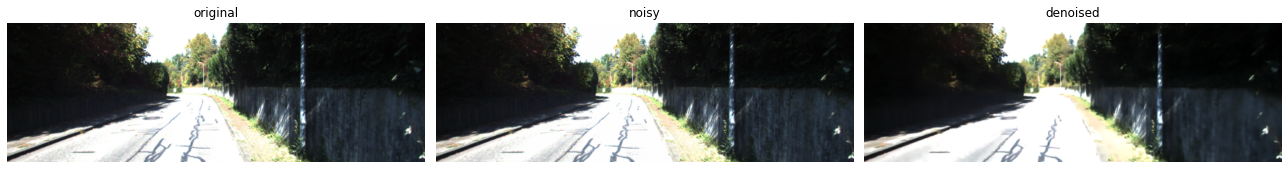

noise_std: 1.00, mae: 4.35


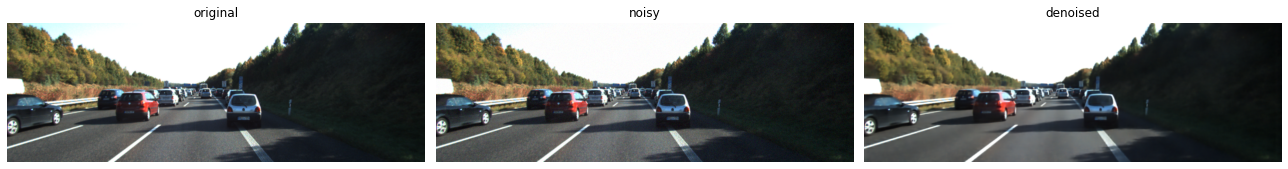

noise_std: 5.00, mae: 3.38


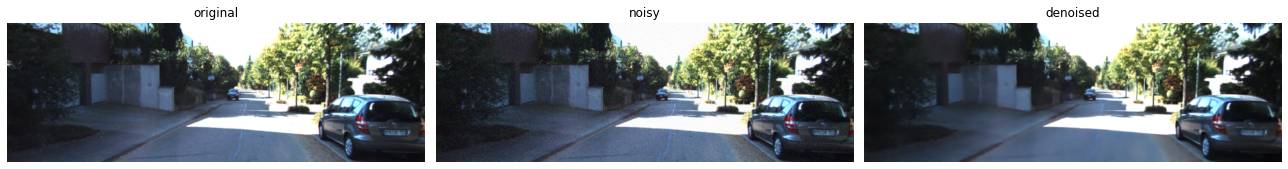

noise_std: 10.00, mae: 4.24


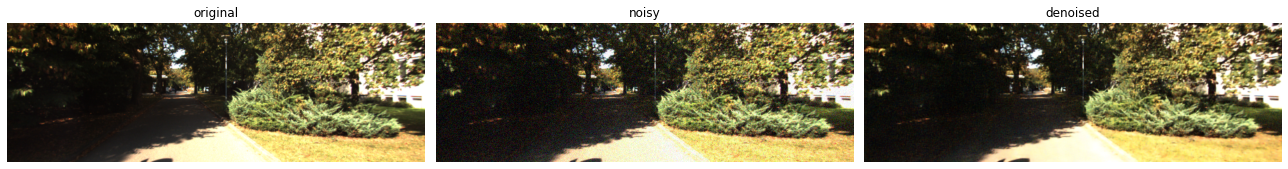

noise_std: 20.00, mae: 6.76


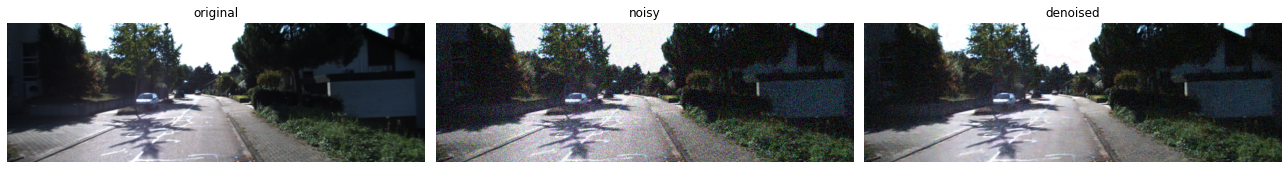

noise_std: 30.00, mae: 7.99


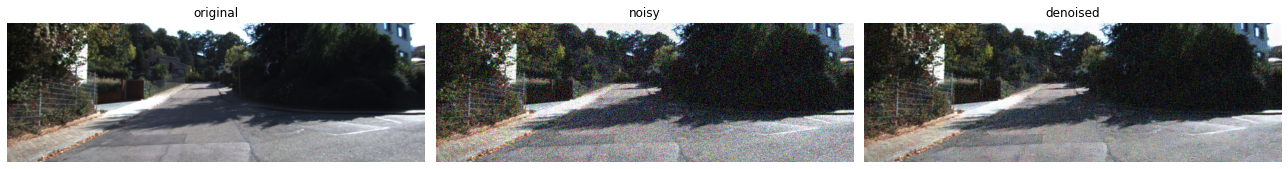

noise_std: 40.00, mae: 11.79


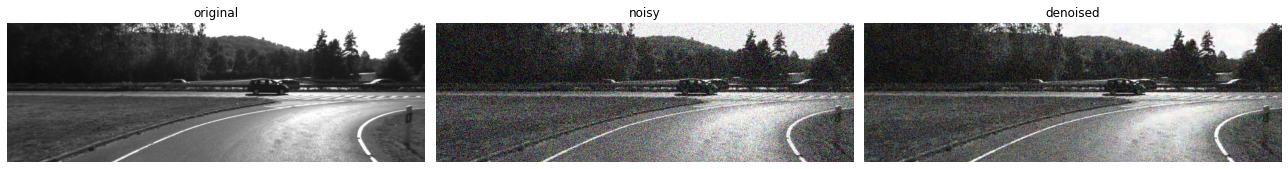

noise_std: 50.00, mae: 15.87


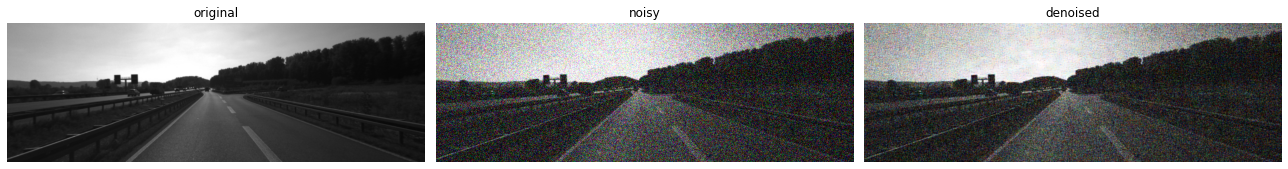

noise_std: 60.00, mae: 17.78


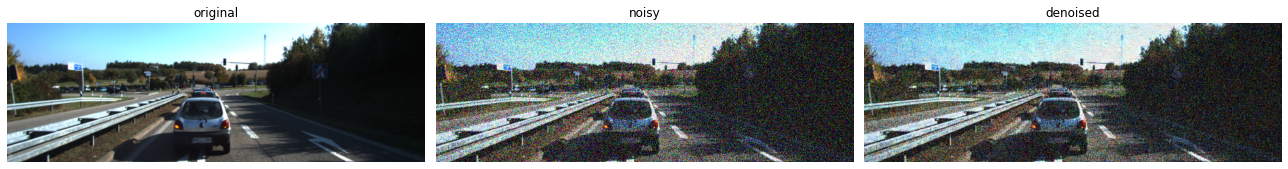

noise_std: 70.00, mae: 21.57


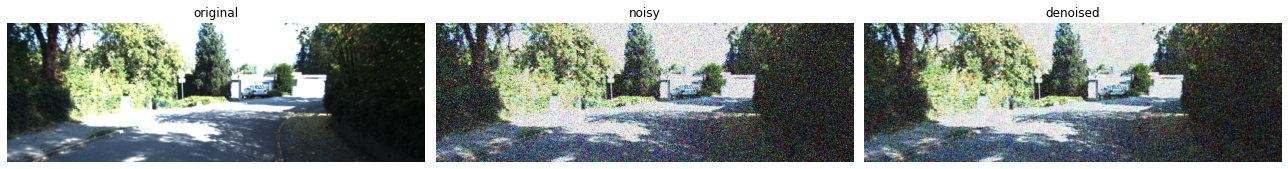

noise_std: 80.00, mae: 26.21


In [80]:
SHOW_IMAGES = True
FIG_SIZE = (18, 6)
VISUALIZE_FIG_SIZE = (20,12)
NOISE_STD = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80]
RESOLUTIONS= [(128, 384), (256,768)]
MODEL = "resnet_color_laplacian_3x5_non_shared_bn_16x3x3_128x128_residual"
KITTI_IMAGES_SAMPLE = KITTI_IMAGES

model = bfcnn.load_model(MODEL)
img_path = KITTI_IMAGES_SAMPLE[2]
resolution = (256, 768)
model_name = MODEL

df = \
    pd.DataFrame(
        columns=[
            "mae",
            "mse",
            "noise_std",
        ])


for index, noise_std in enumerate(NOISE_STD):
    img_path = KITTI_IMAGES_SAMPLE[index % len(KITTI_IMAGES_SAMPLE)]
    img = \
        tf.keras.preprocessing.image.load_img(
            path=img_path,
            color_mode="rgb",
            target_size=resolution,
            interpolation="bilinear")
    img_original = \
        tf.keras.preprocessing.image.img_to_array(
            img=img)
    img_original = tf.expand_dims(img_original, axis=0)
    img_original = tf.cast(img_original, dtype=tf.uint8)
    img_noisy = \
        tf.cast(img_original, dtype=tf.float32) + \
        tf.random.truncated_normal(
            mean=0,
            stddev=noise_std,
            shape=img_original.shape)
    img_noisy = tf.clip_by_value(img_noisy, clip_value_min=0, clip_value_max=255)
    img_noisy = tf.round(img_noisy)
    img_noisy = tf.cast(img_noisy, dtype=tf.uint8)
    img_denoised = model(img_noisy)
    # ---
    img_noisy_np = img_noisy.numpy()
    img_original_np = img_original.numpy()
    img_denoised_np = img_denoised.numpy()
    assert img_denoised_np.shape == img_original_np.shape
    assert img_denoised_np.shape == img_noisy_np.shape
    # --- calculate mae, mse
    mae = \
        np.mean\
            (np.abs(img_original_np.astype("float") - img_denoised_np.astype("float")),
             axis=None)
    mse = \
        np.mean\
            (np.square(img_original_np.astype("float") - img_denoised_np.astype("float")),
             axis=None)
    # --- append df

    df = \
        pd.concat([
            df,
            pd.DataFrame({
                "mae": f"{mae:0.2f}",
                "mse": f"{mse:0.2f}",
                "noise_std": f"{noise_std}"
            }, index=[0])],
        ignore_index=True)

    # --- visualize or not
    if SHOW_IMAGES:
        norm = plt.Normalize(0, 255)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=FIG_SIZE)
        im0 = axes[0].imshow(img_original_np[0,:,:,:], norm=norm)
        im1 = axes[1].imshow(img_noisy_np[0,:,:,:], norm=norm)
        im2 = axes[2].imshow(img_denoised_np[0,:,:,:], norm=norm)
        axes[0].set_title(f"original")
        axes[0].axis("off")
        axes[1].set_title(f"noisy")
        axes[1].axis("off")
        axes[2].set_title(f"denoised")
        axes[2].axis("off")
        plt.tight_layout()
        plt.show()
        print(f"noise_std: {noise_std:0.2f}, mae: {mae:0.2f}")

In [81]:
display(df)


mae      mse noise_std
0   4.35    47.64         1
1   3.38    23.88         5
2   4.24    40.75        10
3   6.76    85.72        20
4   7.99   112.67        30
5  11.79   231.65        40
6  15.87   409.08        50
7  17.78   538.54        60
8  21.57   807.79        70
9  26.21  1152.98        80